In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils
import math
from collections import defaultdict

(Text(0.5, 1.0, 'Original Image'), ([], []), ([], []))

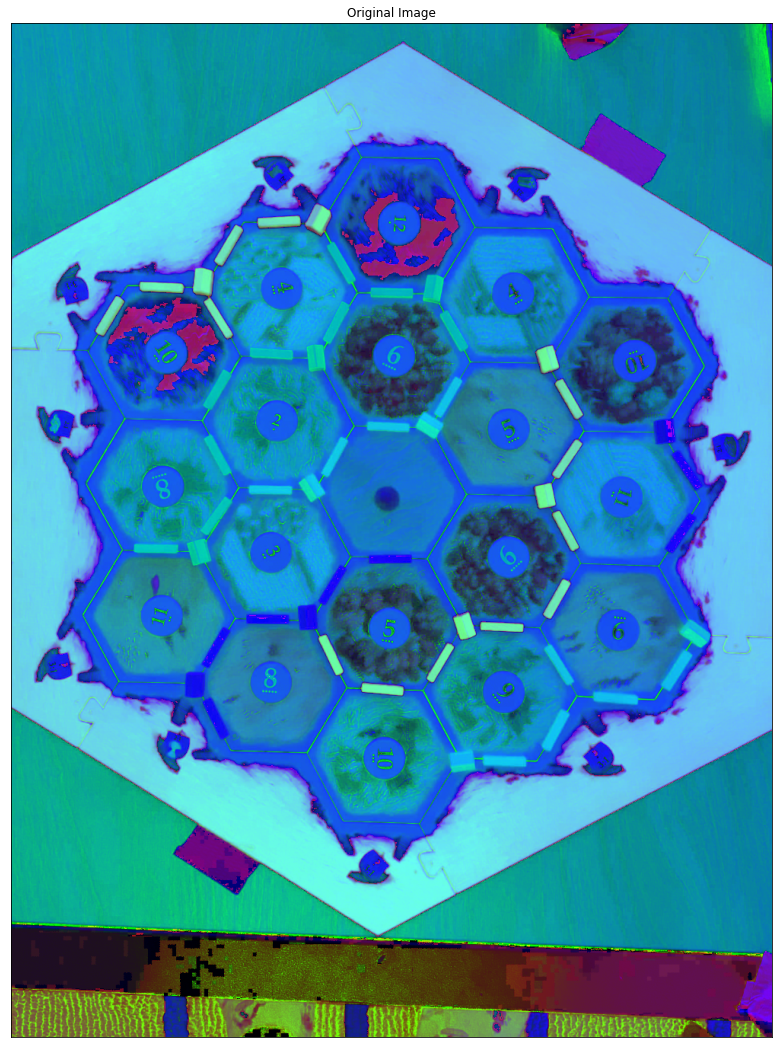

In [3]:
############################################
# Read image and get canny edge detection
############################################

# read img
img = cv.imread('photos/testimg3.jpg')[:,:,::-1]
# pad_size = 100
# img = cv.copyMakeBorder(img,pad_size, pad_size, pad_size, pad_size,cv.BORDER_CONSTANT,value=(0, 0, 0))
img = imutils.resize(img, width=1000)
img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

# get canny
edges = cv.Canny(img,100,300)

# see img
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(img_hsv)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

20


([], [])

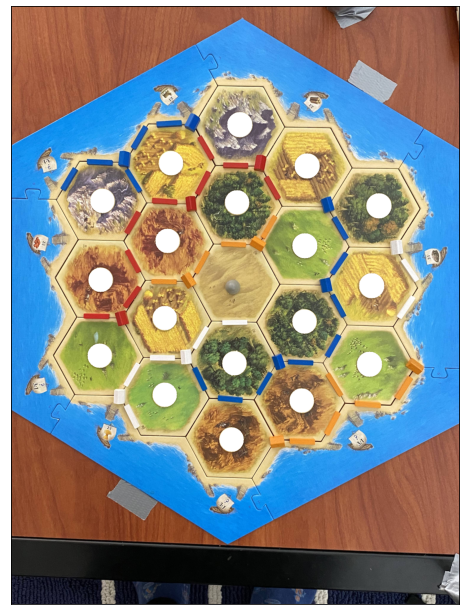

In [4]:
############################################
# get each number circle
############################################

circles = cv.HoughCircles(img_gray,cv.HOUGH_GRADIENT_ALT,1,20,
                            param1=50,param2=.92,minRadius=10,maxRadius=50)
circles = np.uint16(np.around(circles))[0,:,0:3]
circles_img = img.copy()
average_circle_radius = 20
for circ in circles:
    cv.circle(circles_img,(circ[0],circ[1]),circ[2],(255,255,255),-1)
print(average_circle_radius)
plt.figure(figsize=(11,11))
plt.imshow(circles_img)
plt.xticks([])
plt.yticks([])

174.4882966688129


([], [])

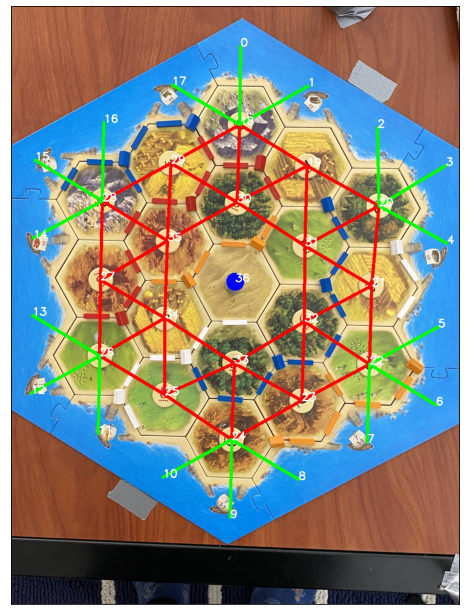

In [5]:
#########################
# get average distance
#########################

num_short_distances = 3 * 6 + 4 * 6 + 6 * 5
all_distances = []

circles = np.array(circles, dtype=np.float64)
def distanceBetweenCircles(c1, c2):
    return math.sqrt(((c1[0] - c2[0]) ** 2) + ((c1[1] - c2[1]) ** 2))

for i in range(len(circles)):
    for j in range(len(circles)):
        if (i != j):
            all_distances.append(distanceBetweenCircles(circles[i], circles[j]))

all_distances.sort()


short_distances_sum = 0
for i in range(num_short_distances):
    short_distances_sum += all_distances[i]

average_distance = short_distances_sum / num_short_distances
print(average_distance)
distance_range = 55

img_copy = img.copy()
circles_map = defaultdict(list)
for i in range(len(circles)):
    for j in range(len(circles)):
        if (distanceBetweenCircles(circles[i], circles[j]) >= average_distance - distance_range and distanceBetweenCircles(circles[i], circles[j]) <= average_distance + distance_range):
            circles_map[i].append(j)
            cv.line(img_copy, (int(circles[i][0]), int(circles[i][1])), (int(circles[j][0]), int(circles[j][1])), (255, 0, 0), 5)

def angleBetweenCircles(c1, c2):
    delta_x = c2[0] - c1[0]
    delta_y = c2[1] - c1[1]
    return math.atan2(delta_y, delta_x)

# get outer circles
outer_circles = []
inner_circles = []
outer_real_circles = []
current_outer_circle = None
top_most_outer_y = 9999
top_most_outer_real_y = 9999
top_most_inner_y = 9999
for key in circles_map:
    val = circles_map[key]
    if (len(val) == 3):
        cur_angles = []
        for other_c in val:
            cur_angles.append((math.pi * 2) + angleBetweenCircles(circles[key], circles[other_c]))
        cur_angles.sort()
        if (cur_angles[1] - cur_angles[0] - (math.pi / 6) > 1):
            cur_angles[0] += (math.pi * 2)
        if (cur_angles[2] - cur_angles[1] - (math.pi / 6) > 1):
            cur_angles[2] -= (math.pi * 2)
        cur_angles.sort()
        
        # add other angles
        maxAngle = cur_angles[2]
        for i in range(3):
            maxAngle += math.pi / 3
            newX = circles[key][0] + (average_distance * math.cos(maxAngle))
            newY = circles[key][1] + (average_distance * math.sin(maxAngle))
            cv.line(img_copy, (int(circles[key][0]), int(circles[key][1])), (int(newX), int(newY)), (0, 255, 0), 5)
            outer_circles.append([newX, newY])
            top_most_outer_y = min(top_most_outer_y, newY)
            if (i == 1):
                current_outer_circle = [newX, newY]
            if (i == 0):
                next_outer_circle = [newX, newY]

    elif (len(val) == 5):
        inner_circles.append(circles[key])
        top_most_inner_y = min(top_most_inner_y, circles[key][1])
    
    if (len(val) != 5):
        outer_real_circles.append(circles[key])
        top_most_outer_real_y = min(top_most_outer_real_y, circles[key][1])

# get center circle
average_inner_x = 0
average_inner_y = 0
for c in inner_circles:
    average_inner_x += c[0]
    average_inner_y += c[1]
average_inner_x /= 6
average_inner_y /= 6

center_circle = [average_inner_x, average_inner_y]

cv.circle(img_copy, (int(average_inner_x), int(average_inner_y)), 20, (0, 0, 255), -1)

# number
def sort_circles(c):
  return angleBetweenCircles(c, center_circle)

cars = ['Ford', 'Mitsubishi', 'BMW', 'VW']

# find top most outer circle
outer_circles.sort(key=sort_circles)
top_most_outer_y_index = 0
num_outer_circles = len(outer_circles)
for i in range(len(outer_circles)):
    cur_c = outer_circles[i]
    if (cur_c[1] == top_most_outer_y):
        top_most_outer_y_index = i
        break
outer_circles += outer_circles

# find top most outer real circle
outer_real_circles.sort(key=sort_circles)
top_most_outer_real_y_index = 0
num_outer_real_circles = len(outer_real_circles)
for i in range(len(outer_real_circles)):
    cur_c = outer_real_circles[i]
    if (cur_c[1] == top_most_outer_real_y):
        top_most_outer_real_y_index = i
        break
outer_real_circles += outer_real_circles

# find top most inner circles
inner_circles.sort(key=sort_circles)
top_most_inner_y_index = 0
num_inner_circles = len(inner_circles)
for i in range(len(inner_circles)):
    cur_c = inner_circles[i]
    if (cur_c[1] == top_most_inner_y):
        top_most_inner_y_index = i
        break
inner_circles += inner_circles


points = []
point_num = 0
for i in range(top_most_outer_y_index, top_most_outer_y_index + num_outer_circles):
    cur_c = outer_circles[i]
    # cv.putText(img_copy, str(point_num), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
    point_num += 1
    points.append([cur_c[0], cur_c[1]])

for i in range(top_most_outer_real_y_index, top_most_outer_real_y_index + num_outer_real_circles):
    cur_c = outer_real_circles[i]
    #cv.putText(img_copy, str(point_num), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
    point_num += 1
    points.append([cur_c[0], cur_c[1]])
    
for i in range(top_most_inner_y_index, top_most_inner_y_index + num_inner_circles):
    cur_c = inner_circles[i]
    # cv.putText(img_copy, str(point_num), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
    point_num += 1
    points.append([cur_c[0], cur_c[1]])


# cv.putText(img_copy, str(point_num), (int(center_circle[0]), int(center_circle[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
points.append([center_circle[0], center_circle[1]])

for i in range(len(points)):
    cur_c = points[i]
    cv.putText(img_copy, str(i), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)

plt.figure(figsize=(11,11))
plt.imshow(img_copy)
plt.xticks([])
plt.yticks([])




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

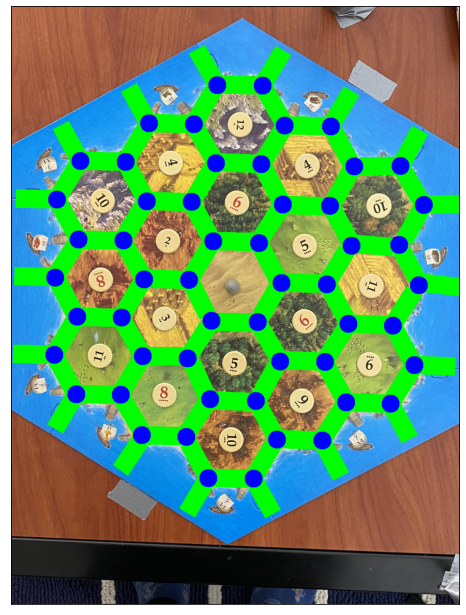

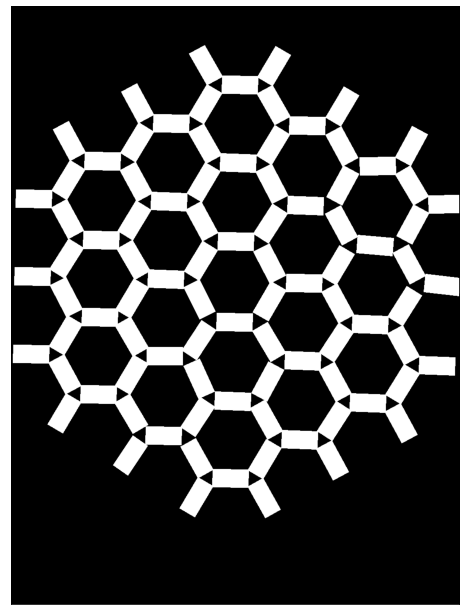

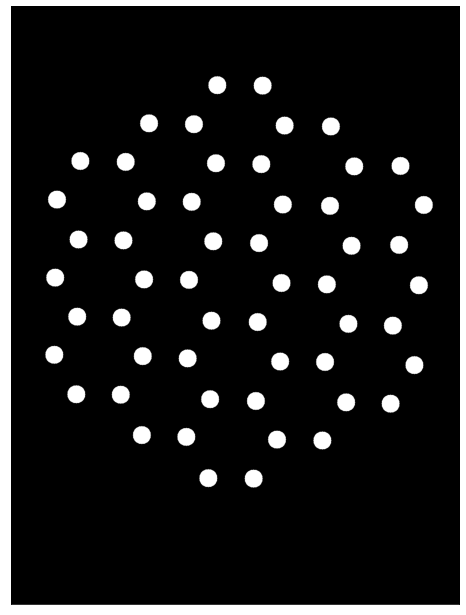

In [6]:
###########################
# Find settlement locations
###########################


test_img = img.copy()
# go around ordered circle and find all neighbors
neighbor_sets = {}
neighbors = []
for i in range(len(points)):
    neighbors = []
    color = list(np.random.random(size=3) * 256)
    for j in range(len(points)):
        if (distanceBetweenCircles(points[i], points[j]) >= average_distance - distance_range and distanceBetweenCircles(points[i], points[j]) <= average_distance + distance_range):
            neighbors.append(j)
            cv.line(test_img, (int(points[i][0]), int(points[i][1])), (int(points[j][0]), int(points[j][1])), color, 5)
    neighbor_sets[i] = neighbors

check_loc_img = img.copy()
road_mask_all = np.zeros(img.shape)
settlement_mask_all = np.zeros(img.shape)

check_road_radius = 50
check_settlement_radius = 20

def get_point_from_angle_dist(orig, ang, dist):
    return (orig[0]+dist*math.cos(ang), orig[1]+dist*math.sin(ang))

# find possible road locations
box_w = 80
box_h = 40
road_locs = []
road_masks = []
for num in neighbor_sets:
    first_pt = points[num]
    for neighbor in neighbor_sets[num]:
        road_mask = np.zeros(img.shape)
        second_pt = points[neighbor]
        road_loc = (int((first_pt[0]+second_pt[0])/2), int((first_pt[1]+second_pt[1])/2))
        road_locs.append({"pts":[first_pt, second_pt], "loc":road_loc, "mask":road_mask, "neighbors":[num, neighbor]})
        # cv.circle(check_loc_img, road_loc, 30, (0,255,0), 2)
        # compute rectangle corners
        ang = angleBetweenCircles(first_pt, second_pt)
        dist = np.sqrt((box_h/2)**2 + (box_w/2)**2)
        alpha = math.atan2((box_h/2),(box_w/2))
        beta = np.pi/2-alpha
        ang1 = ang+beta
        ang2 = ang1+2*alpha
        ang3 = ang-beta
        ang4 = ang3-2*alpha
        pt1 = get_point_from_angle_dist(road_loc, ang1, dist)
        pt2 = get_point_from_angle_dist(road_loc, ang2, dist)
        pt3 = get_point_from_angle_dist(road_loc, ang3, dist)
        pt4 = get_point_from_angle_dist(road_loc, ang4, dist)
        box_pts = np.array([[pt1],[pt2],[pt4],[pt3]],np.int32)
        box_pts = box_pts.reshape((-1, 1, 2))
        # cv.polylines(check_loc_img, [box_pts], True, (0,255,0), 2)
        cv.fillPoly(check_loc_img, [box_pts], (0,255,0))
        cv.fillPoly(road_mask, [box_pts], (255,255,255))
        cv.fillPoly(road_mask_all, [box_pts], (255,255,255))
        # cv.circle(road_mask_all, road_loc, check_road_radius, (255,255,255), -1)
        # cv.circle(road_mask, road_loc, check_road_radius, (255,255,255), -1)
        road_masks.append(road_mask)

## find possible settlement locations
# make copy of neighbors
# find dists between neighboring neighbors
# find centroid of each neighbor triplet
settlement_locs = []
settlement_masks = []
for num in neighbor_sets:
    first_pt = points[num]
    neighbors_copy = neighbor_sets[num]

    # compute dists between all neighbors
    neighbor_pts = np.array(points)[np.array(neighbors_copy)]
    n_dists = []
    for i, n_1 in enumerate(neighbors_copy):
        for j, n_2 in enumerate(neighbors_copy):
            if (i < j):
                dist = distanceBetweenCircles(neighbor_pts[i], neighbor_pts[j])
                if dist < 200:
                    n_dists.append([n_1,n_2])
    for pair in n_dists:
        settlement_mask = np.zeros(img.shape)
        second_pt = points[pair[0]]
        third_pt = points[pair[1]]
        settlement_loc = (int((first_pt[0]+second_pt[0]+third_pt[0])/3),int((first_pt[1]+second_pt[1]+third_pt[1])/3))
        settlement_locs.append({"pts":[first_pt, second_pt, third_pt], "loc":settlement_loc, "mask":settlement_mask, "neighbors":pair})
        cv.circle(check_loc_img, settlement_loc, 20, (0,0,255), -1)
        cv.circle(settlement_mask_all, settlement_loc, check_settlement_radius, (255,255,255), -1)
        settlement_masks.append(settlement_mask)

plt.figure(figsize=(11,11))
plt.imshow(check_loc_img)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(11,11))
plt.imshow(road_mask_all)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(11,11))
plt.imshow(settlement_mask_all)
plt.xticks([])
plt.yticks([])

([], [])

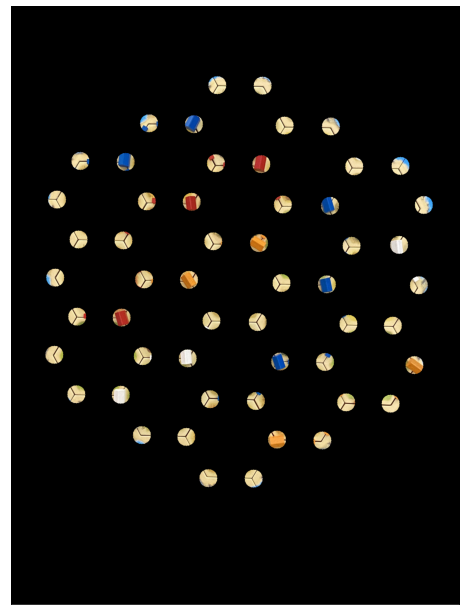

In [7]:

possible_settles_img = np.where(settlement_mask_all==0, 0, img)


plt.figure(figsize=(11,11))
plt.imshow(possible_settles_img)
plt.xticks([])
plt.yticks([])

In [8]:
##########################
# Get color for each point
##########################

def getTypeFromAvgHSV(hsv):
    type = 'none'
    if hsv[0] >= 15 and hsv[0] <= 25 and \
        hsv[1] >= 100 and hsv[1] <= 160 and \
        hsv[2] >= 160 and hsv[2] <= 225:
        type = 'wheat'
    elif hsv[0] >= 8 and hsv[0] <= 27 and \
        hsv[1] >= 80 and hsv[1] <= 145 and \
        hsv[2] >= 100 and hsv[2] <= 180:
        type = 'brick'
    elif hsv[0] >= 50 and hsv[0] <= 145 and \
        hsv[1] >= 28 and hsv[1] <= 55 and \
        hsv[2] >= 100 and hsv[2] <= 175:
        type = 'stone'
    elif hsv[0] >= 26 and hsv[0] <= 75 and \
        hsv[1] >= 25 and hsv[1] <= 110 and \
        hsv[2] >= 75 and hsv[2] <= 135:
        type = 'wood'
    elif hsv[0] >= 32 and hsv[0] <= 45 and \
        hsv[1] >= 80 and hsv[1] <= 150 and \
        hsv[2] >= 120 and hsv[2] <= 200:
        type = 'sheep'
    return type


e = 15
num_pts = 10
tiles = {}
for i in range(18, 36):
    circ = points[i]
    avg = [0, 0, 0]
    for j in range(1,num_pts+1):
        x = int(circ[0] + (e+average_circle_radius)*np.cos(j*2*np.pi/10))
        y = int(circ[1] + (e+average_circle_radius)*np.sin(j*2*np.pi/10))
        avg += img_hsv[y, x, :]
    avg = avg/num_pts
    # points[i].append(getTypeFromAvgHSV(avg))
    tiles[i] = getTypeFromAvgHSV(avg)

print(tiles)

{18: 'stone', 19: 'wheat', 20: 'wood', 21: 'wheat', 22: 'sheep', 23: 'brick', 24: 'brick', 25: 'sheep', 26: 'sheep', 27: 'brick', 28: 'stone', 29: 'wheat', 30: 'wood', 31: 'sheep', 32: 'wood', 33: 'wood', 34: 'wheat', 35: 'brick'}


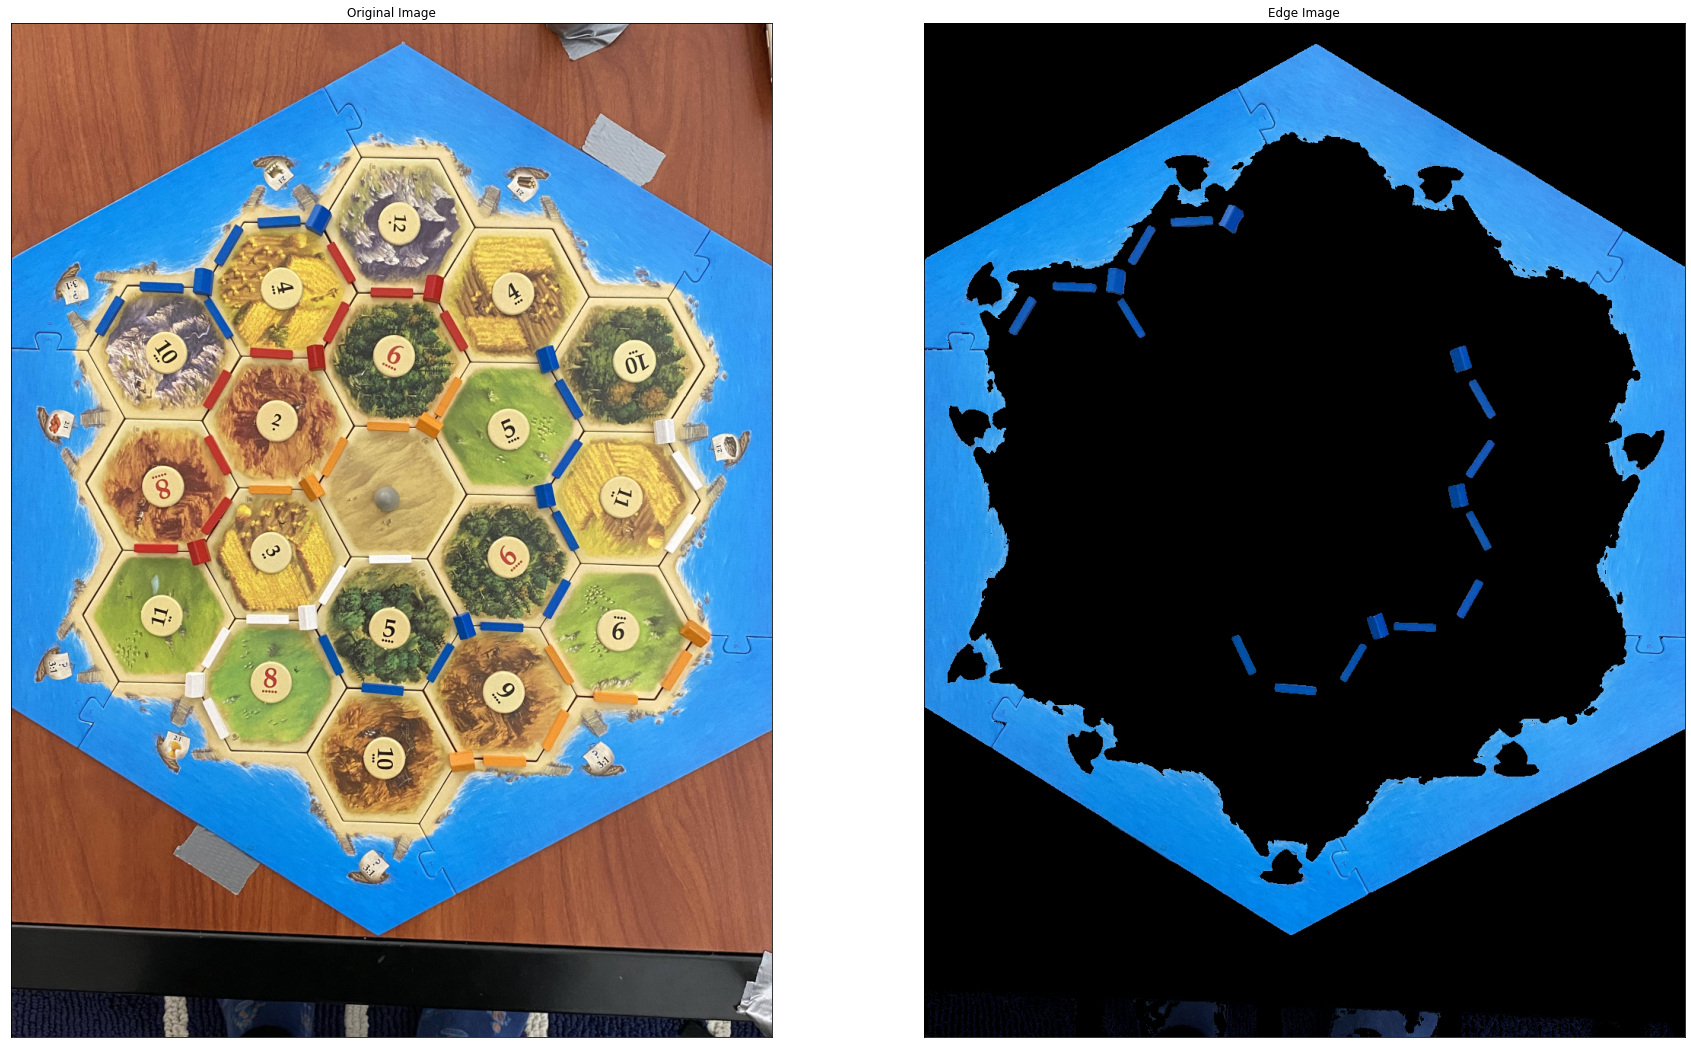

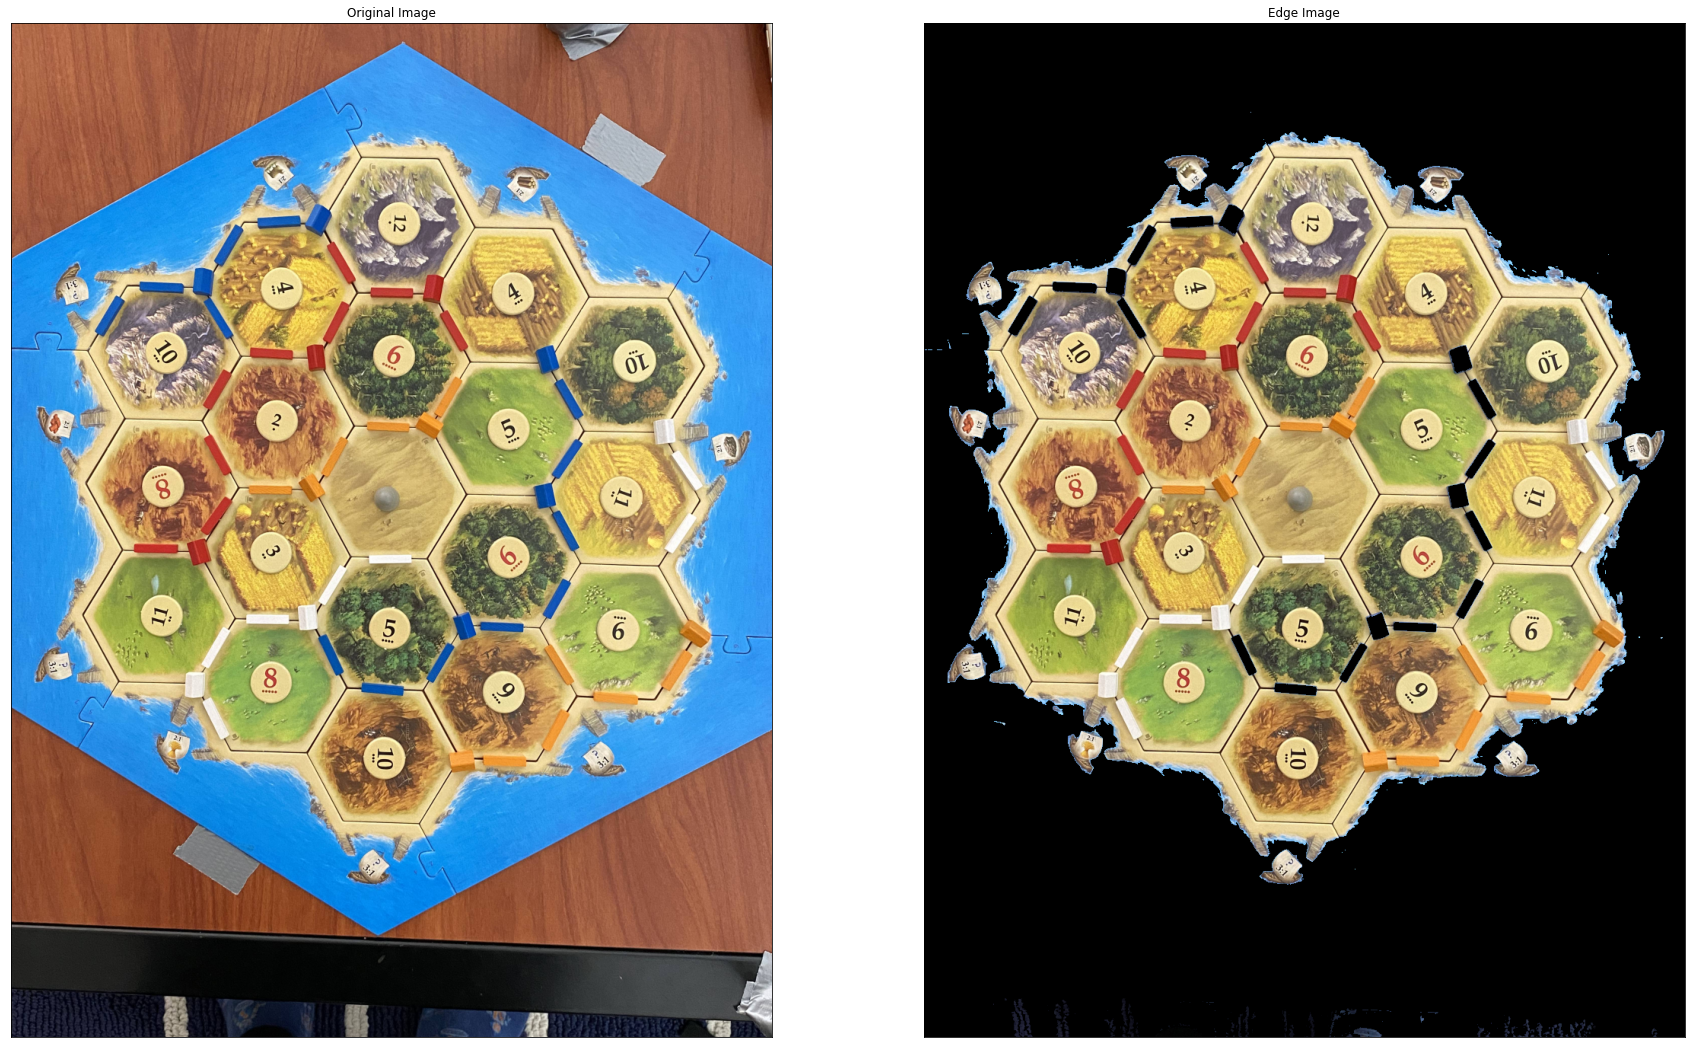

622
498


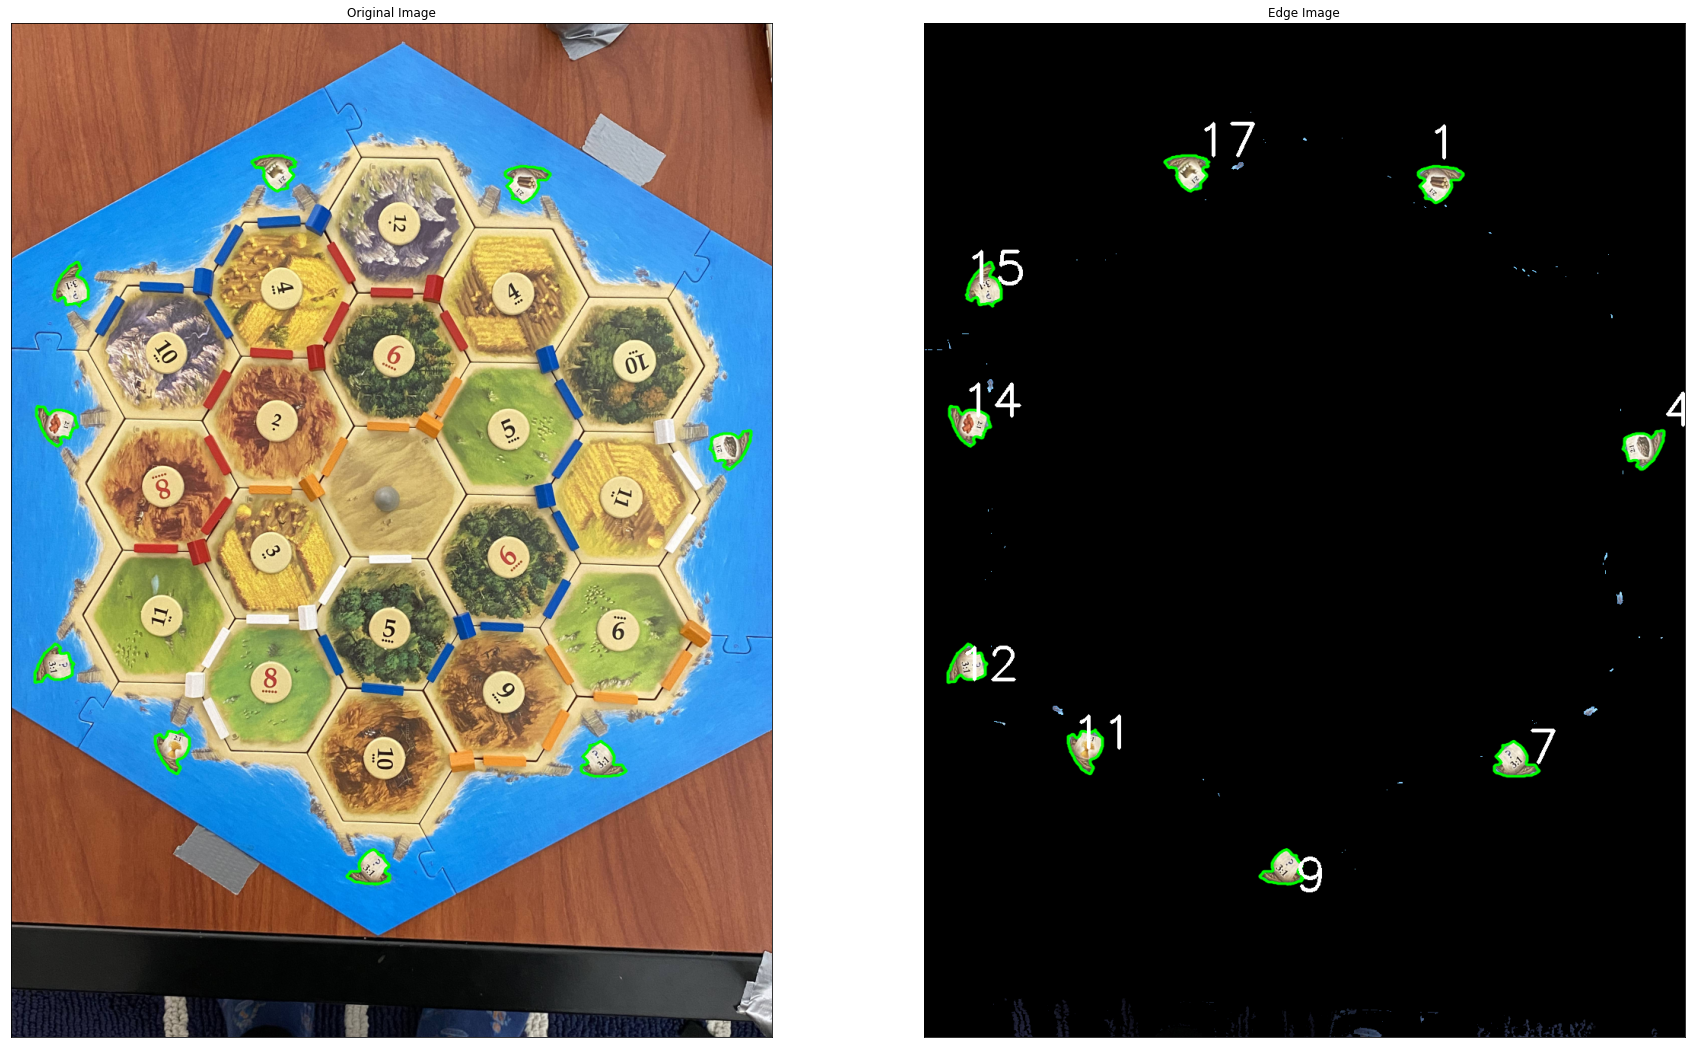

In [16]:
################
# Get blue mask
################

# create boundaries
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
blue_lower=np.array([80,140,0],np.uint8)
blue_upper=np.array([140,255,255],np.uint8)

# find mask
blue_mask = cv.inRange(hsv, blue_lower, blue_upper)

# see img
res = cv.bitwise_and(img,img, mask= blue_mask)
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(res)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()
############################
# Expand blue mask outwards
############################

# create masks
blue_mask_binary = img.copy()
h, w = img.shape[:2]
flood_mask = np.zeros((h+2, w+2), np.uint8)

# flood fill the 4 corners
cv.floodFill(blue_mask, flood_mask, (0,0), 255)
cv.floodFill(blue_mask, flood_mask, (w-1,0), 255)
cv.floodFill(blue_mask, flood_mask, (0,h-1), 255)
cv.floodFill(blue_mask, flood_mask, (w-1,h-1), 255)

# see img
blue_mask_inv = cv.bitwise_not(blue_mask)
cropped_img = cv.bitwise_and(img,img, mask=blue_mask_inv)
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cropped_img)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()
####################
# Get ship contours
####################

# get center of mass
mass_x, mass_y = np.where(blue_mask <= 0)
cent_x = int(np.average(mass_x))
cent_y = int(np.average(mass_y))
print(cent_x)
print(cent_y)

# get ship mask
ship_flood_mask = np.zeros((h+2, w+2), np.uint8)
ship_mask = blue_mask.copy()
cv.floodFill(ship_mask, ship_flood_mask, (cent_x,cent_y), 255)
ship_mask_inv = cv.bitwise_not(ship_mask)

# find contours
contours, hierarchy = cv.findContours(image=ship_mask_inv, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)

# sort contours in decreasing order and take first 9
contours = sorted(contours, key=lambda x:cv.contourArea(x), reverse=True)
contours = contours[0:9]

# draw contours on the original image
image_copy = img.copy()
cv.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
ship_img = cv.bitwise_and(img,img, mask=ship_mask_inv)
cv.drawContours(image=ship_img, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)

        

            
def distanceFromShipAndPoint(ship, point):
    M = cv.moments(ship)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return math.sqrt( ((cX - point[0])**2) + ((cY - point[1])**2))

shipPoints = []
for c in contours:
    minDistance = 99999
    minPoint = 0
    for i in range(18):
        curDistance = distanceFromShipAndPoint(c, points[i])
        if curDistance < minDistance:
            minPoint = i
            minDistance = curDistance
    shipPoints.append(minPoint)
for index in shipPoints:
    cv.putText(ship_img, str(index), (int(points[index][0]), int(points[index][1])), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
# see ship img
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(image_copy)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(ship_img)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

([], [])

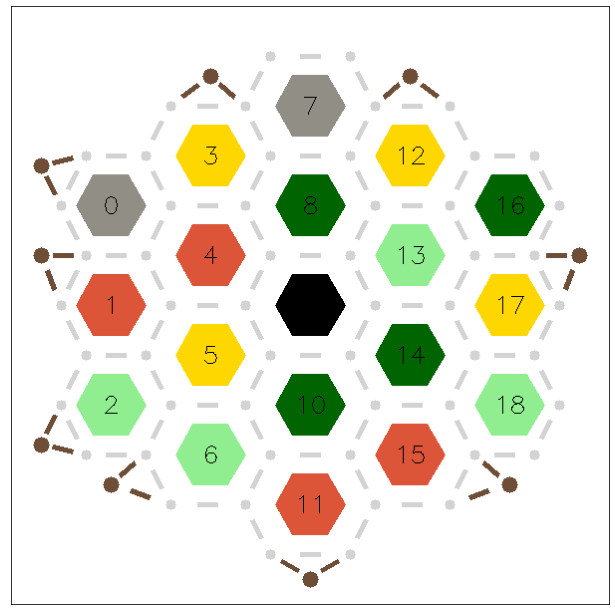

In [48]:
##############################
# Create simulated game board
##############################

blank_image = np.zeros((600,600,3), np.uint8)
blank_image[:] = 255

tile_num = [28, 27, 26, 29, 35, 34, 25, 18, 30, 36, 33, 24, 19, 31, 32, 23, 20, 21, 22]
YCoordinates = [200, 300, 400, 150, 250, 350, 450, 100, 200, 300, 400, 500, 150, 250, 350, 450, 200, 300, 400]
XCoordinates = [100, 100, 100, 200, 200, 200, 200, 300, 300, 300, 300, 300, 400, 400, 400, 400, 500, 500, 500]

roadSettlements = [[3, 0], [0, 4], [4, 1], [1, 5], [5, 2], [2, 6], [6, 10], [10, 15], [15, 20], [20, 26], [26, 32], [32, 37], [37, 42], [42, 46], [46, 50], [50, 53], [53, 49], [49, 52], [52, 48], [48, 51], [51, 47], [47, 43], [43, 38], [38, 33], [33, 27], [27, 21], [21, 16], [16, 11], [11, 7], [7, 3], [12, 8], [8, 13], [13, 9], [9, 14], [14, 19], [19, 25], [25, 31], [31, 36], [36, 41], [41, 45], [45, 40], [40, 44], [44, 39], [39, 34], [34, 28], [28, 22], [22, 17], [17, 12], [23, 18], [18, 24], [24, 30], [30, 35], [35, 29], [29, 23], [7, 12], [4, 8], [5, 9], [14, 10], [25, 20], [31, 37], [41, 46], [45, 49], [44, 48], [39, 43], [28, 33], [22, 16], [17, 23], [18, 13], [24, 19], [30, 36], [35, 40], [29, 34]]

settlementYCoodinates = [200, 300, 400, 150, 250, 350, 450, 150, 250, 350, 450, 100, 200, 300, 400, 500, 100, 200, 300, 400, 500, 50, 150, 250, 350, 450, 550, 50, 150, 250, 350, 450, 550, 100, 200, 300, 400, 500, 100, 200, 300, 400, 500, 150, 250, 350, 450, 150, 250, 350, 450, 200, 300, 400]
settlementXCoodinates = []
for i in range(3):
    settlementXCoodinates.append(50)
for i in range(4):
    settlementXCoodinates.append(75)
for i in range(4):
    settlementXCoodinates.append(135)
for i in range(5):
    settlementXCoodinates.append(160)
for i in range(5):
    settlementXCoodinates.append(235)
for i in range(6):
    settlementXCoodinates.append(260)
for i in range(6):
    settlementXCoodinates.append(340)
for i in range(5):
    settlementXCoodinates.append(365)
for i in range(5):
    settlementXCoodinates.append(440)
for i in range(4):
    settlementXCoodinates.append(465)
for i in range(4):
    settlementXCoodinates.append(525)
for i in range(3):
    settlementXCoodinates.append(550)

ship_num = [0, 17, 1, 16, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9]
shipCoordinatesY = [25, 70, 70, 120, 120, 160, 160, 250, 250, 350, 350, 440, 440, 480, 480, 530, 530, 575]
shipCoordinatesX = [300, 200, 400, 100, 500, 30, 570, 30, 570, 30, 570, 30, 570, 100, 500, 200, 400, 300]

ship_map = {}
for i in range(len(ship_num)):
    ship_map[ship_num[i]] = [shipCoordinatesX[i], shipCoordinatesY[i]]

shipToSettlement = {
   0: [21, 27],
   1: [33, 38],
   2: [38, 43],
   3: [47, 51],
   4: [48, 52],
   5: [52, 49],
   6: [53, 50],
   7: [42, 46],
   8: [37, 42],
   9: [26, 32],
   10: [15, 20],
   11: [10, 15],
   12: [2, 6],
   13: [1, 5],
   14: [1, 4],
   15: [0, 3],
   16: [7, 11],
   17: [11, 16]
}

def typeToColor(type):
    woodColor = (0,100,0)
    sheepColor = (144,238,144)
    wheatColor = (255,215,0)
    stoneColor = (145, 142, 133)
    brickColor = (220, 85, 57)

    if type == "wheat":
        return wheatColor
    if type == "brick":
        return brickColor
    if type == "stone":
        return stoneColor
    if type == "wood":
        return woodColor
    if type == "sheep":
        return sheepColor

    return (0, 0, 0)

def get_point_from_angle_dist(orig, ang, dist):
    return (orig[0]+dist*math.cos(ang), orig[1]+dist*math.sin(ang))
    
def drawRoad(img, first_pt, second_pt, color):
    box_w = 4
    box_h = 20
    ang = angleBetweenCircles(first_pt, second_pt)
    dist = np.sqrt((box_h/2)**2 + (box_w/2)**2)
    alpha = math.atan2((box_h/2),(box_w/2))
    beta = np.pi/2-alpha
    ang1 = ang+beta
    ang2 = ang1+2*alpha
    ang3 = ang-beta
    ang4 = ang3-2*alpha
    road_loc = (int((first_pt[0]+second_pt[0])/2), int((first_pt[1]+second_pt[1])/2))
    pt1 = get_point_from_angle_dist(road_loc, ang1, dist)
    pt2 = get_point_from_angle_dist(road_loc, ang2, dist)
    pt3 = get_point_from_angle_dist(road_loc, ang3, dist)
    pt4 = get_point_from_angle_dist(road_loc, ang4, dist)
    box_pts = np.array([[pt1],[pt2],[pt4],[pt3]],np.int32)
    box_pts = box_pts.reshape((-1, 1, 2))
    # cv.polylines(check_loc_img, [box_pts], True, (0,255,0), 2)
    cv.fillPoly(img, [box_pts], color)


coordinates = {}
for i in range(len(XCoordinates)):
    coordinates[tile_num[i]] = [XCoordinates[i], YCoordinates[i]]

    pts = []
    cur_angle = -math.pi / 3
    for p in range(6):
        radius = 35
        pointX = XCoordinates[i] + radius * math.cos(cur_angle)
        pointY = YCoordinates[i] + radius * math.sin(cur_angle)
        cur_angle += math.pi / 3
        pts.append([int(pointX), int(pointY)])
    pts = np.asarray(pts)
    pts = pts.reshape((-1,1,2)) 
    
    if (tile_num[i] == 36):
        cv.fillPoly(blank_image, [pts], (0, 0, 0))
        # cv.putText(blank_image, str(tile_num[i]), (XCoordinates[i] - 20, YCoordinates[i] - 15), cv.FONT_HERSHEY_SIMPLEX, .3, (255, 255, 255), 1)
       # cv.putText(blank_image, str(i), (XCoordinates[i], YCoordinates[i]), cv.FONT_HERSHEY_SIMPLEX, .3, (0, 0, 0), 1)
    else:
        cur_color = typeToColor(tiles[tile_num[i]])
        cv.fillPoly(blank_image, [pts], cur_color)
        # cv.putText(blank_image, str(tile_num[i]), (XCoordinates[i] - 20, YCoordinates[i] - 15), cv.FONT_HERSHEY_SIMPLEX, .3, (0, 0, 0), 1)
        if (i < 10):
            cv.putText(blank_image, str(i), (XCoordinates[i] - 8, YCoordinates[i] + 8), cv.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 0), 1)
        else:
            cv.putText(blank_image, str(i), (XCoordinates[i] - 16, YCoordinates[i] + 8), cv.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 0), 1)


for i in range(len(settlementXCoodinates)):
    cv.circle(blank_image, (settlementXCoodinates[i], settlementYCoodinates[i]), 5, (211, 211, 211), -1)
    # cv.putText(blank_image, str(i), (settlementXCoodinates[i], settlementYCoodinates[i]), cv.FONT_HERSHEY_SIMPLEX, .3, (0, 0, 0), 1)
    
for settlementPair in roadSettlements:
    drawRoad(blank_image, (settlementXCoodinates[settlementPair[0]], settlementYCoodinates[settlementPair[0]]), (settlementXCoodinates[settlementPair[1]], settlementYCoodinates[settlementPair[1]]), (211, 211, 211))

for pointIndex in shipPoints:
    shipSettlements = shipToSettlement[pointIndex]
    cv.circle(blank_image, (ship_map[pointIndex][0], ship_map[pointIndex][1]), 8, (111, 78, 55), -1)
    drawRoad(blank_image, (ship_map[pointIndex][0], ship_map[pointIndex][1]), (settlementXCoodinates[shipSettlements[0]], settlementYCoodinates[shipSettlements[0]]), (111, 78, 55))
    drawRoad(blank_image, (ship_map[pointIndex][0], ship_map[pointIndex][1]), (settlementXCoodinates[shipSettlements[1]], settlementYCoodinates[shipSettlements[1]]), (111, 78, 55))

plt.figure(figsize=(11,11))
plt.imshow(blank_image)
plt.xticks([])
plt.yticks([])